# The Oslo Model

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import curve_fit
from collections import Counter
from logbin230119 import logbin

%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams.update({'font.size': 22})
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1.2
plt.rcParams['ytick.minor.width'] = 1.2

In [3]:
def slope(h, i):
    z_i = h[i] - h[i+1]
    return z_i

def rand_slope_th(weighting):
    z_th = np.random.choice([1,2], p=weighting)
    return z_th

def crossover_time(z):
    t_c = 0
    for i in range(len(z)):
        t_c += z[i] * (i+1)
    return t_c

def avg_crossover_time(N, iterations, L, weighting):
    t_c_sum = 0
    for runs in range(N):
        z, h, pile_height_t, tc, avalanches = oslo(iterations, L, weighting, crossover=True)
        t_c_sum += tc
    t_c_avg = t_c_sum / N
    return t_c_avg

def smooth_height(M, iterations, L, weighting):
    smooth_h = [0 for i in range(iterations)]
    for m in range(M):
        z, h, pile_height_t, tc, avalanches = oslo(iterations, L, weighting)
        for i in range(iterations):
            smooth_h[i] += pile_height_t[i] / M
    return smooth_h

def scaling_func(L, a_0, a_1, w_1):
    return a_0 * L * (1 - a_1 * L**(-w_1))

def power_func(x, a, b):
    return a * x ** b

def linear_func(x, a, b):
    return a * x + b

def gauss_func(x, mean, sigma):
    return (1/(sigma *np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mean)/sigma)**2)

def oslo(iterations, L, weighting, crossover=False):
    '''
    Algorithm for the one-dimensional boundary-driven Oslo model, when threshold slope probability
    weighting is [0.5, 0.5]. 
    
    Parameters
    ----------
    iterations: int
        Number of grains to be added to the system
    
    L: int
        Size of the system
    
    weighting: list
        Threshold slope probability weighting for values of 1 and 2
        
    crossover: bool
        If True, breaks iterations when the cross-over time is reached
    
    Returns
    -------
    z: list
        Slope configuration at end of iterations
    
    h: list
        Height configuration at end of iterations
    
    pile_height_t: list
        List of total height of pile over time
    
    tc: int
        Cross-over time of system
        
    avalanches: list
        List of all avalanches that occur
        
    '''
    h = [0 for i in range(L+1)] #extra term for boundary condition h_(L+1) = 0
    pile_height_t = []
    pile_height = 0
    z = [0 for i in range(L)]
    z_th = [rand_slope_th(weighting) for i in range(L)]
    tc = 0
    avalanches = []
    
    for n in range(iterations):
        #drive
        h[0] += 1
        pile_height += 1
        h[-1] = 0
        z[0] = slope(h, 0)
        checklist = [0]
        tc_check = 0
        avalanche_size = 0

        #relaxation
        while len(checklist) != 0:
            for i in checklist:
                while z[i] > z_th[i]:
                    if i == 0:
                        z[0] += -2
                        h[0] += -1
                        pile_height += -1
                        z[1] += 1
                        h[1] += 1
                        if z[1] > z_th[1]:
                            checklist.append(1)
                    elif i == L-1:
                        z[L-1] += -1
                        h[L-1] += -1
                        z[L-2] += 1
                        if z[-2] > z_th[-2]:
                            checklist.append(L-2)
                        
                        if tc_check==0:
                            tc = crossover_time(z)
                            tc_check = 1
                        else:
                            pass
                        
                        if crossover:
                            break 
                    else: 
                        z[i] += -2
                        h[i] += -1
                        z[i+1] += 1
                        h[i+1] += 1
                        if z[i+1] > z_th[i+1]:
                            checklist.append(i+1)
                        z[i-1] += 1
                        if z[i-1] > z_th[i-1]:
                            checklist.append(i-1)
                    z_th[i] = rand_slope_th(weighting)
                    avalanche_size += 1

                checklist.remove(i)
                
                if tc!=0 and crossover:
                    break
                
        for p in range(len(z)):
            if z[p] > z_th[p]:
                print("Error at ", p)

        pile_height_t.append(pile_height)
        avalanches.append(avalanche_size)
        
        if tc!=0 and crossover:
            break

    return z, h, pile_height_t, tc, avalanches

## Testing the model

Slopes of BTW model for system of size L=10 over 1,000 iterations:

In [192]:
L = 10
iterations = 1000
weighting = [1,0] #BTW model
z, h, pile_height_t, tc, avalanches = oslo(iterations, L, weighting)
#slopes of BTW should be 1 at all sites
print(z)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Slopes of Oslo model for system of size L=10 over 1,000 iterations:

In [193]:
weighting = [0.5, 0.5] #Oslo model
z, h, pile_height_t, tc, avalanches = oslo(iterations, L, weighting)
print(z)

[1, 1, 1, 2, 1, 2, 2, 2, 2, 1]


Obtains total number of grains in full system (cross-over time) for system of size L=100 over 10,000 iterations (p=1):

In [194]:
L = 100
iterations = 10000
weighting = [1,0]
z, h, pile_height_t, tc, avalanches = oslo(iterations, L, weighting, crossover=True)
print(tc)
print(0.5*L*(L+1))

5050
5050.0


Obtains total number of grains in full system (cross-over time) for system of size L=100 over 10,000 iterations (p=0):

In [130]:
iterations = 100000
weighting = [0,1]
z, h, pile_height_t, tc, avalanches = oslo(iterations, L, weighting, crossover=True)
print(tc)
print(L*(L+1))

10100
10100


Plot of pile height vs. time for L=50 over 3,000 iterations, using p=1 (BTW), p=0 and p=0.5 (Oslo):

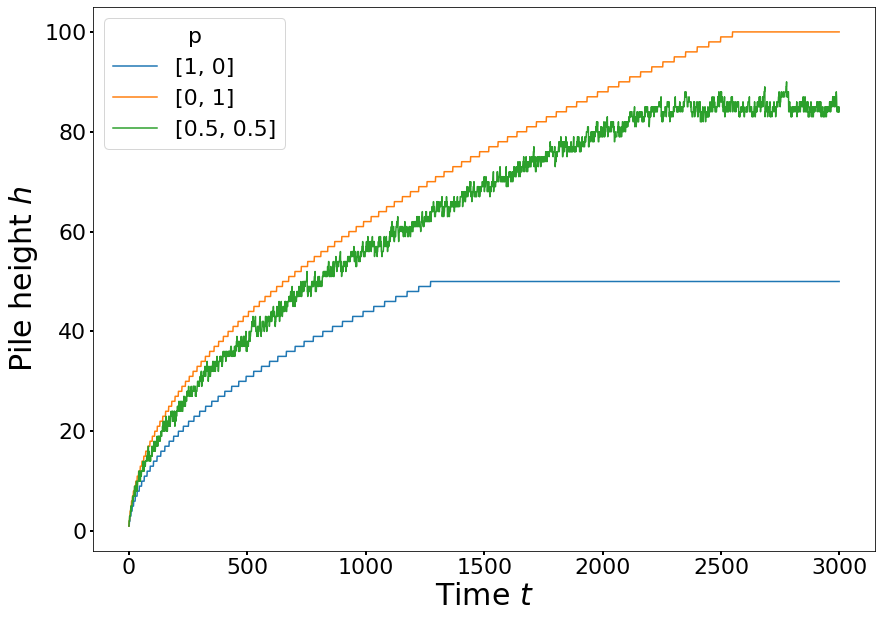

In [195]:
L = 50
iterations = 3000
for i in [[1,0], [0,1], [0.5,0.5]]:
    weighting = i
    z, h, pile_height_t, tc, avalanches = oslo(iterations, L, weighting)
    plt.plot(pile_height_t, label=i)
plt.xlabel("Time $t$", fontsize = 30)
plt.ylabel("Pile height $h$", fontsize = 30)
plt.legend(title='p')
plt.show()

Obtains average height for system size L=16 and L=32 over 10,000 iterations:

In [918]:
iterations = 10000
for L in [16, 32]:
    z, h, pile_height_t, tc, avalanches = oslo(iterations, L, weighting)
    print("L: ", L, np.average(pile_height_t[tc:]))

L:  16 26.52957457713993
L:  32 53.8654945054945


## Height of pile *h(t;L)* vs time *t*

Plot of height vs. time for system of size L=16:

crossover:  236


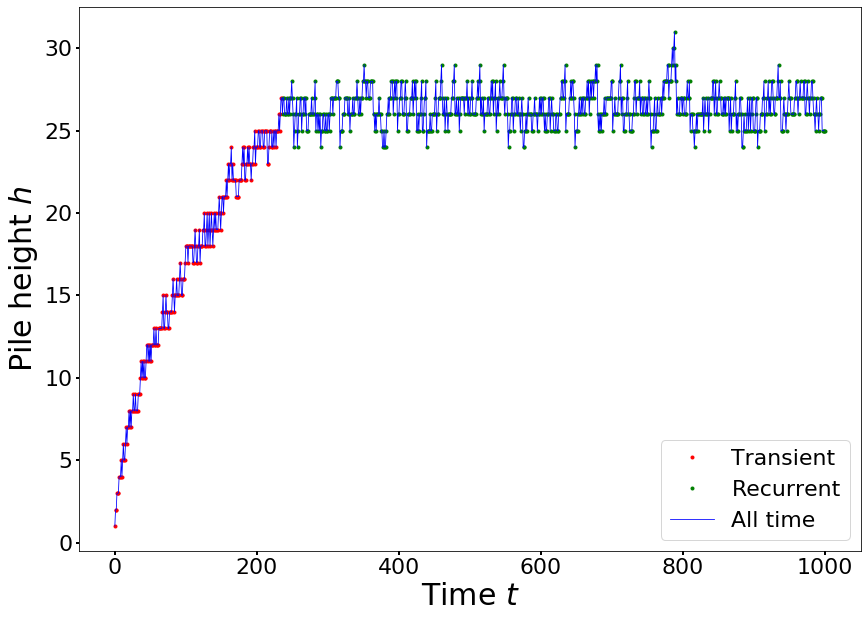

In [196]:
L = 16
iterations = 1000
weighting = [0.5, 0.5]

z, h, pile_height_t, tc, avalanches = oslo(iterations, L, weighting)

print("crossover: ", tc)

t = np.linspace(0, iterations, iterations)
plt.xlabel("Time $t$", fontsize=30)
plt.ylabel("Pile height $h$", fontsize=30)
plt.plot(pile_height_t[0:tc], '.', color='red', label="Transient", linewidth=4)
plt.plot(t[tc:], pile_height_t[tc:], '.', color='green', label="Recurrent", linewidth=4)
plt.plot(pile_height_t, color='blue', label="All time", linewidth=0.8)
plt.legend()
plt.show()

Obtains and saves data for height vs. time for all system sizes over 100,000 iterations:

In [ ]:
L_list = [4, 8, 16, 32, 64, 128, 256]
iterations = 100000
weighting = [0.5,0.5]
L_pile_heights = []

for L in L_list:
    print(L)
    z, h, pile_height_t, tc, avalanches = oslo(iterations, L, weighting)
    L_pile_heights.append(pile_height_t)

np.savetxt('height_vs_t_rangeL.txt', L_pile_heights)

Plot of height vs. time for all system sizes:

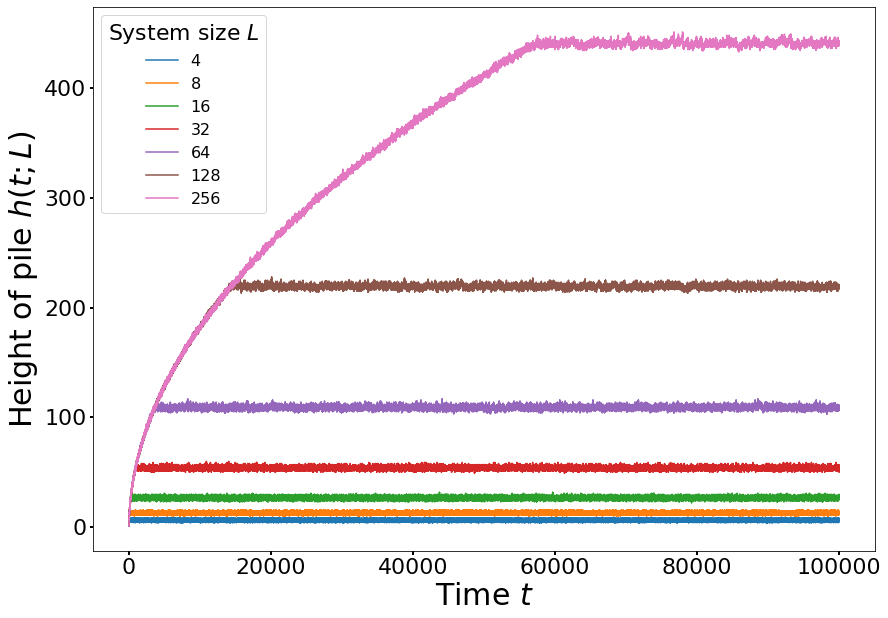

In [197]:
iterations = 100000
L_pile_heights = np.loadtxt('height_vs_t_rangeL.txt')
t = np.linspace(0, iterations, iterations)
for i in range(len(L_pile_heights)):
    plt.plot(t, L_pile_heights[i], label = L_list[i])
plt.xlabel("Time $t$", fontsize = 30)
plt.ylabel("Height of pile $h(t;L)$", fontsize = 30)
plt.legend(title = "System size $L$", prop={'size':16})
plt.show()

## Average crossover time <*t<sub>c</sub>*> vs system size *L*

Obtains and saves data for average cross-over times for all system sizes over 100,000 iterations:

In [ ]:
L_list = [4, 8, 16, 32, 64, 128, 256]
tc = []

for L in L_list:
    print(L)
    N = 5
    iterations = 100000
    weighting = [0.5,0.5]
    tc_avg = avg_crossover_time(N, iterations, L, weighting)
    tc.append(tc_avg)

np.savetxt('average_crossover_times.txt', tc)

Plot of average cross-over time vs. system size:

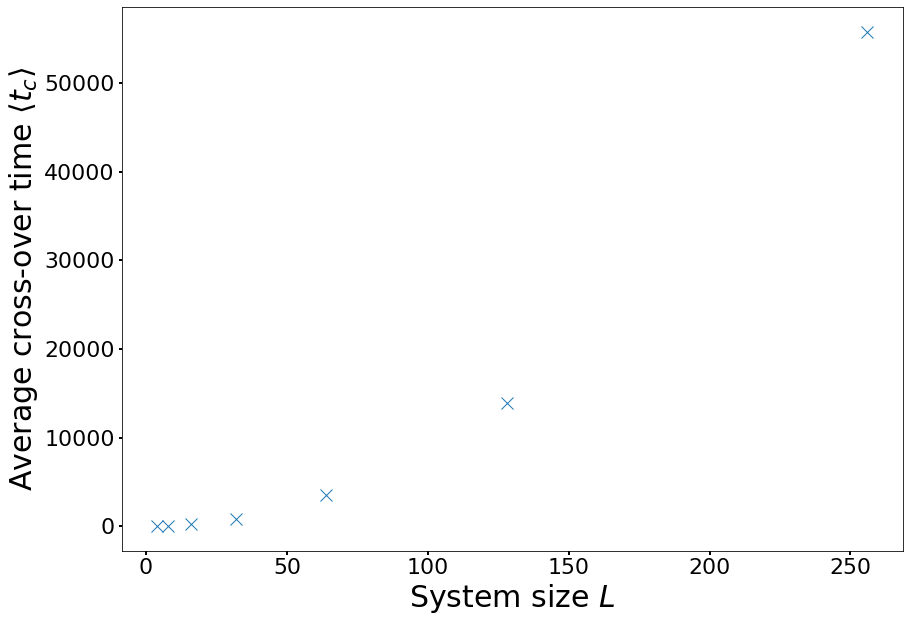

In [174]:
tc = np.loadtxt('average_crossover_times.txt')
plt.plot(L_list, tc, 'x', label='Data points', markersize=12)
plt.xlabel("System size $L$", fontsize = 30)
plt.ylabel(r"Average cross-over time $\langle t_c \rangle$", fontsize = 30)
plt.show()

Log-log plot of average cross-over time vs. system size, with fitted line:

y-intercept: 0.8283588261949774
gradient: 2.004936625282237
error on gradient: 0.005916192725218533


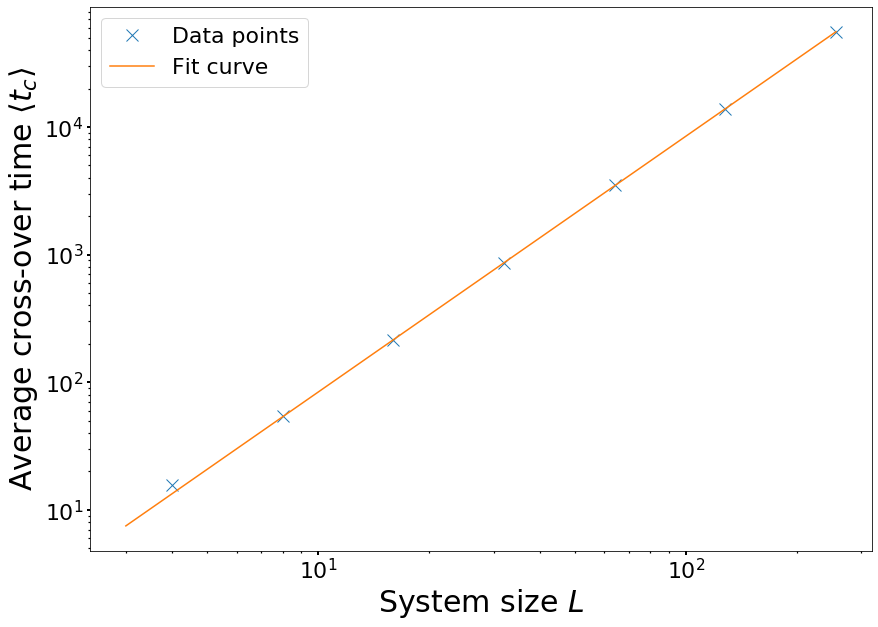

In [177]:
tc = np.loadtxt('average_crossover_times.txt')
plt.loglog(L_list, tc, 'x', label='Data points', markersize=12)
plt.xlabel("System size $L$", fontsize = 30)
plt.ylabel(r"Average cross-over time $\langle t_c \rangle$", fontsize = 30)

fit, cov = curve_fit(power_func, L_list, tc)
x = np.linspace(3, max(L_list))
print("y-intercept:", fit[0])
print("gradient:", fit[1])
print("error on gradient:", np.sqrt(cov[0,0]))

plt.loglog(x, power_func(x, fit[0], fit[1]), label = "Fit curve")
plt.legend()
plt.show()

## Processed height vs time 

Obtains and saves data for smooth averaged height vs. time for all system sizes, over 5 realisations of 100,000 iterations:

In [ ]:
L_list = [4, 8, 16, 32, 64, 128, 256]
processed_height = []

for L in L_list:
    print(L)
    M = 5
    iterations = 100000 
    weighting = [0.5, 0.5]
    processed_height.append(smooth_height(M, iterations, L, weighting))
    
np.savetxt('h_tilda_vs_time.txt', processed_height)

Plot of smooth averaged height vs. time for all system sizes:

/Users/harvey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # Remove the CWD from sys.path while we load stuff.


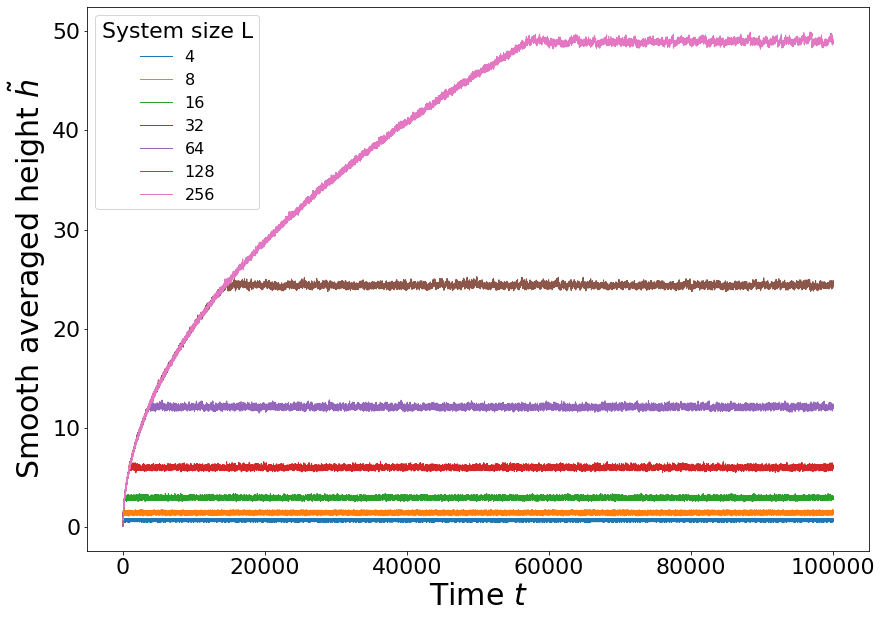

In [645]:
iterations = 100000
L_list = [4, 8, 16, 32, 64, 128, 256]
processed_height = np.loadtxt('h_tilda_vs_time.txt')
t = np.linspace(0, iterations, iterations)
for i in range(len(processed_height)):
    plt.plot(t, processed_height[i], label = L_list[i], linewidth = 1)
plt.xlabel("Time $t$", fontsize = 30)
plt.ylabel("Smooth averaged height $\~{h}$", fontsize = 30)
plt.legend(title = "System size L", prop={'size':16})
plt.show()

Log-log partially-collapsed plot of smooth averaged height vs. time for all system sizes:

/Users/harvey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # This is added back by InteractiveShellApp.init_path()


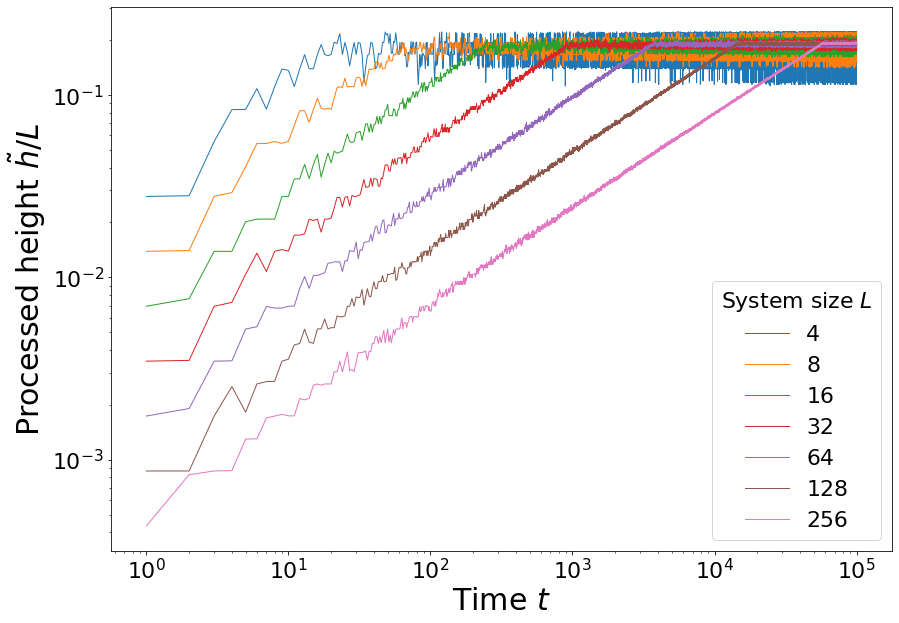

In [1114]:
iterations = 100000
L_list = [4, 8, 16, 32, 64, 128, 256]
processed_height = np.loadtxt('h_tilda_vs_time.txt')
t = np.linspace(1, iterations, iterations)
for i in range(len(processed_height)):
    plt.loglog(t, processed_height[i]/L_list[i]**1.00, label = L_list[i], linewidth = 1)
plt.xlabel("Time $t$", fontsize = 30)
plt.ylabel("Processed height $\~{h}/L$", fontsize = 30)
plt.legend(title = 'System size $L$')
plt.show()

Log-log fully-collapsed plot of smooth average height vs. time for all system sizes:

/Users/harvey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # This is added back by InteractiveShellApp.init_path()


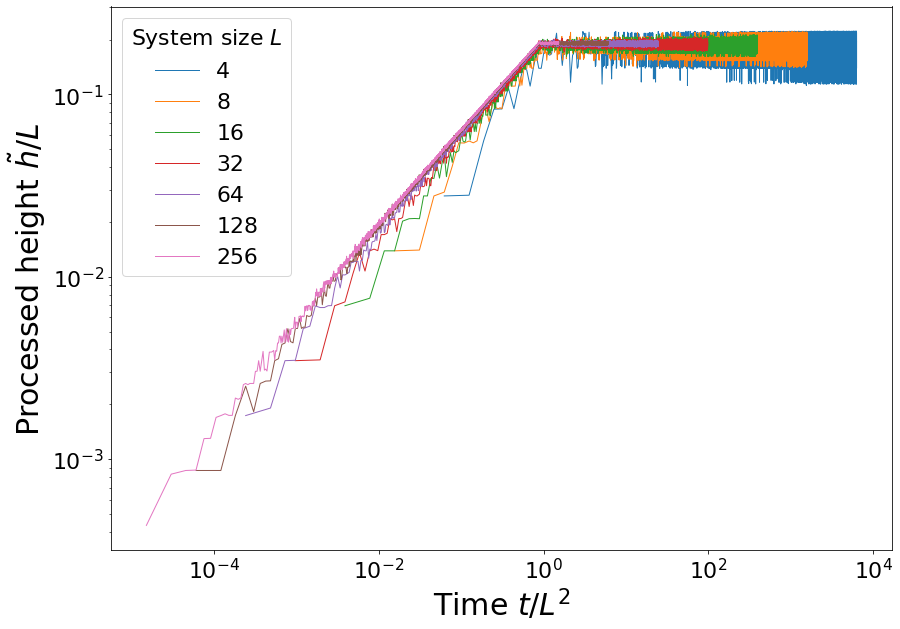

In [1116]:
iterations = 100000
L_list = [4, 8, 16, 32, 64, 128, 256]
processed_height = np.loadtxt('h_tilda_vs_time.txt')
t = np.linspace(1, iterations, iterations)
for i in range(len(processed_height)):
    plt.loglog(t/L_list[i]**2.00, processed_height[i]/L_list[i]**1.00, label = L_list[i], linewidth = 1)
plt.xlabel("Time $t/L^{2}$", fontsize = 30)
plt.ylabel("Processed height $\~{h}/L$", fontsize = 30)
plt.legend(title = 'System size $L$')
plt.show()

Zoomed-in section of the above plot:

/Users/harvey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # This is added back by InteractiveShellApp.init_path()


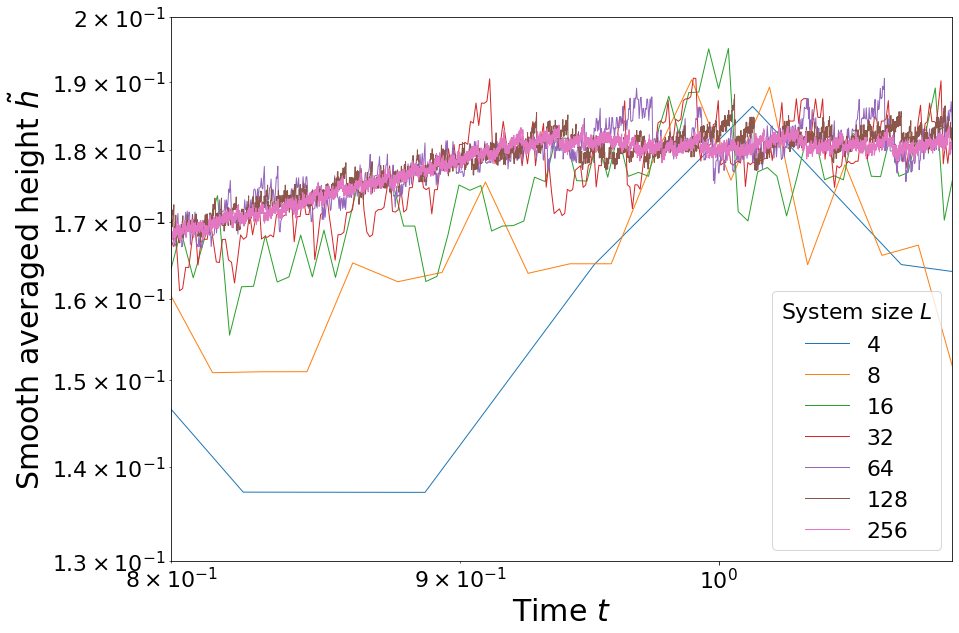

In [934]:
iterations = 100000
L_list = [4, 8, 16, 32, 64, 128, 256]
processed_height = np.loadtxt('h_tilda_vs_time.txt')
t = np.linspace(0, iterations, iterations)
for i in range(len(processed_height)):
    plt.loglog(t/L_list[i]**1.99, processed_height[i]/L_list[i]**1.01, label = L_list[i], linewidth = 1)
plt.xlabel("Time $t$", fontsize = 30)
plt.ylabel("Smooth averaged height $\~{h}$", fontsize = 30)
plt.legend(title = 'System size $L$')
plt.axis((0.8, 1.1, 0.13, 0.2))
plt.show()

Obtains gradient of log-log plot of smooth averaged height vs. time in transient period for L=256:

In [180]:
processed_height = np.loadtxt('h_tilda_vs_time.txt')
tc = np.loadtxt('average_crossover_times.txt')
t = np.linspace(0, tc[-1], tc[-1])
tc_256 = np.int(tc[-1])
(a, b), cov = curve_fit(power_func, t, processed_height[-1][0:tc_256])
std = np.sqrt(np.diag(cov))
print("gradient:", b)
print("error:", std)

gradient: 0.506024383680984
error: [7.64031406e-05 3.81813248e-05]


Plot of smooth averaged height vs. time in transient period for L=256:

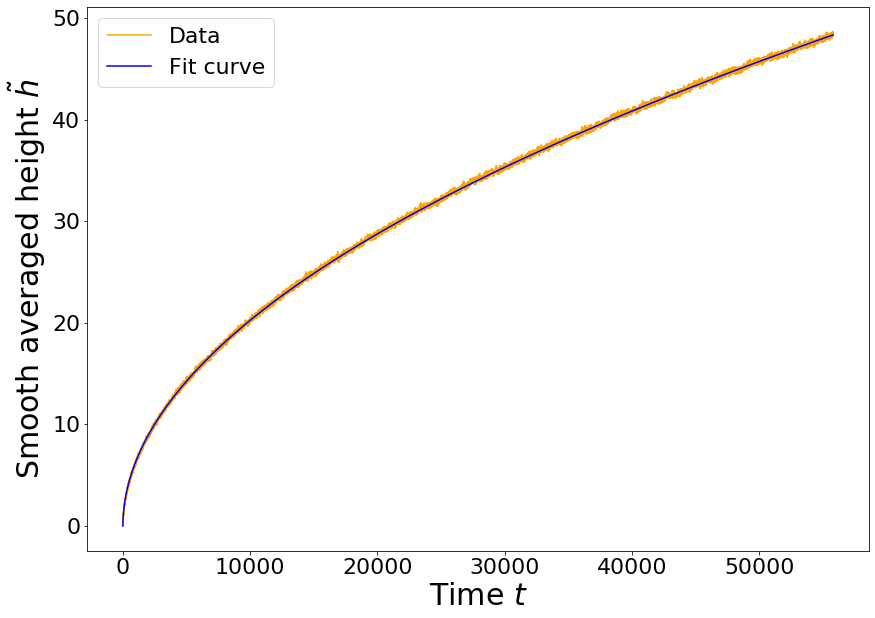

In [11]:
plt.plot(t, processed_height[-1][0:tc_256], label='Data', color='orange')
plt.plot(t, power_func(t, a, b), label='Fit curve', color='blue')

plt.xlabel("Time $t$", fontsize=30)
plt.ylabel("Smooth averaged height $\~{h}$", fontsize=30)
plt.legend()
plt.show()

## Scaling constants

Obtains and saves height of piles over 100,000 iterations for all system sizes:

In [ ]:
steady_state_heights = []
iterations = 100000

for L in L_list:
    z, h, pile_height_t, tc, avalanches = oslo(iterations, L, weighting)
    steady_state = pile_height_t[tc:]
    steady_state_heights.append(steady_state)

np.save('steady_states.npy', steady_state_heights)

Plots the average height in steady state vs. system size:

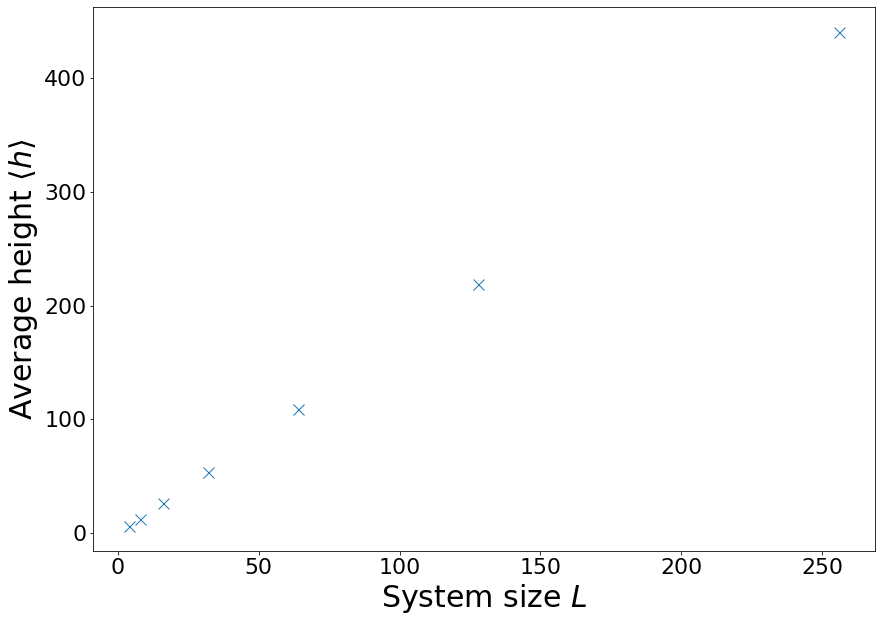

In [93]:
steady_state_heights = np.load('steady_states.npy', allow_pickle=True)
avg_heights = [np.mean(steady_state_heights[i]) for i in range(len(L_list))]
plt.plot(L_list, avg_heights, 'x', ms=11)
plt.xlabel("System size $L$", fontsize = 30)
plt.ylabel(r"Average height $\langle h \rangle$", fontsize = 30)
plt.show()

Fits correction to scaling function to above plot, and obtains parameters:

In [95]:
(a_0, a_1, w_1), cov = curve_fit(scaling_func, L_list, avg_heights)
std = np.sqrt(np.diag(cov))

print("a_0: ", a_0,
      "\na_1: ", a_1,
      "\nw_1: ", w_1,
      "\na_0_std: ", std[0],
     "\na_1_std: ", std[1],
     "\nw_1_std: ", std[2])

a_0:  1.7369630106989868 
a_1:  0.21571888479821855 
w_1:  0.5688207117716765 
a_0_std:  0.001148709274314313 
a_1_std:  0.011827278404569399 
w_1_std:  0.02137557100177257


Same plot as above, but with fitted correction to scaling function:

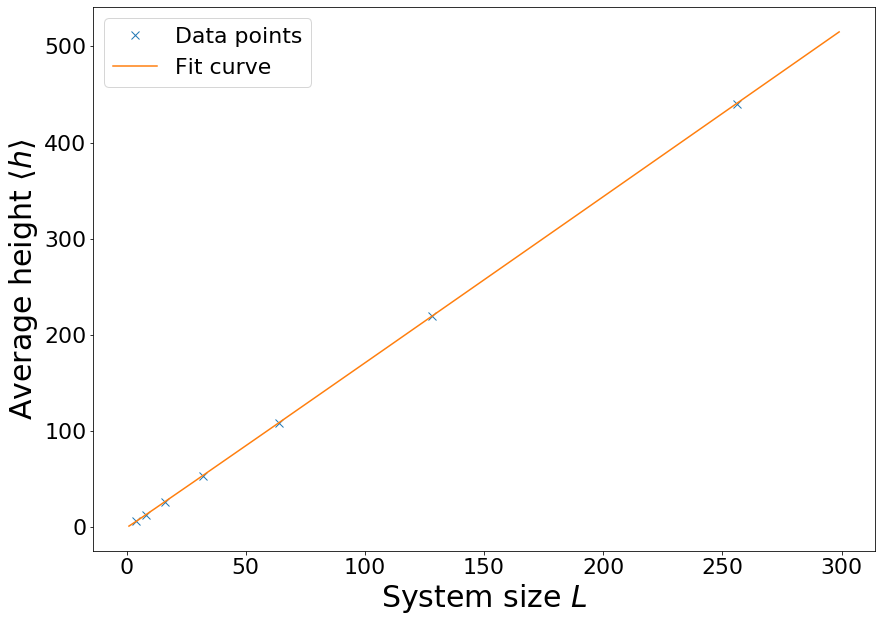

In [97]:
L = np.arange(1, 300)
plt.plot(L_list, avg_heights, 'x', label='Data points', ms=8)
plt.plot(L, scaling_func(L, a_0, a_1, w_1), label='Fit curve')

plt.xlabel("System size $L$", fontsize=30)
plt.ylabel(r"Average height $\langle h \rangle$", fontsize=30)
plt.legend()
plt.show()

Scaled version of above plot, to see effect of corrections to scaling:

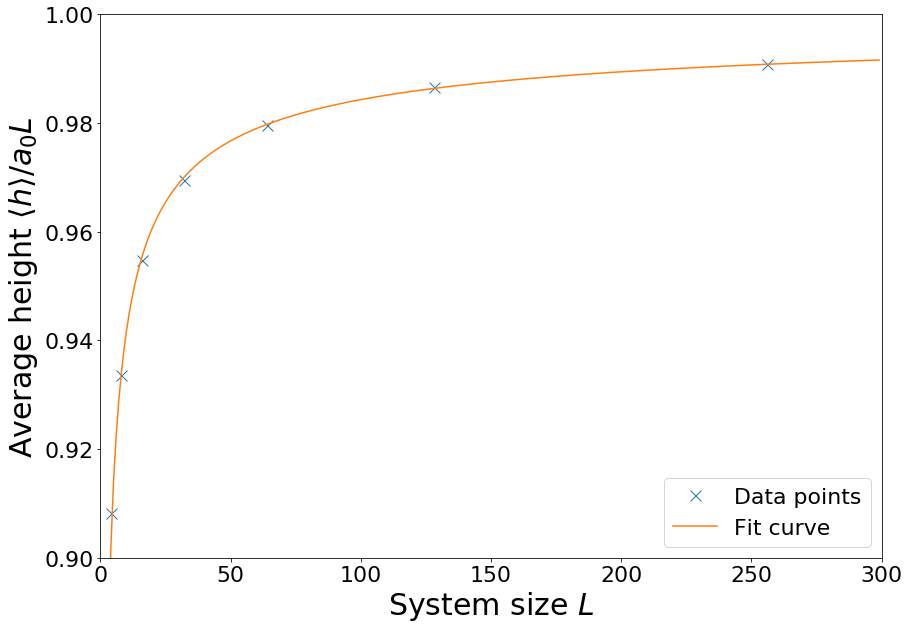

In [98]:
L_list = np.asarray(L_list)
plt.plot(L_list, avg_heights / (a_0 * L_list), 'x', label='Data points', ms=11)
plt.plot(L, scaling_func(L, a_0, a_1, w_1) / (a_0 * L) , label='Fit curve')
plt.xlabel("System size $L$", fontsize=30)
plt.ylabel(r"Average height $\langle h \rangle /a_0L$", fontsize=30)
plt.axis((0, 300, 0.9, 1.0))
plt.legend(loc=4)
plt.show()

## Standard deviation of height vs System size

Plots standard deviation of height vs. system size:

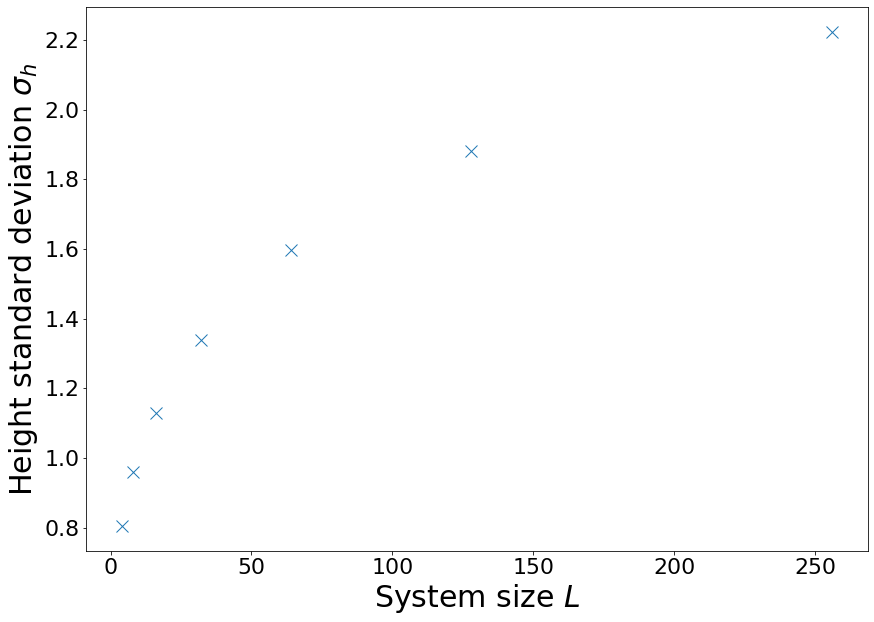

In [100]:
steady_state_heights = np.load('steady_states.npy', allow_pickle=True)
heights_std = [np.std(steady_state_heights[i]) for i in range(len(steady_state_heights))]
plt.plot(L_list, heights_std, 'x', label='Data points', ms=12)

(a, b), cov = curve_fit(power_func, L_list, heights_std)
x = np.linspace(3, 300)
y = power_func(x, a, b)

plt.xlabel("System size $L$", fontsize=30)
plt.ylabel(r"Height standard deviation $\sigma_h$", fontsize=30)
plt.show()

Log-log plot of standard deviation vs. system size, with fitted power law function:

gradient: 0.24377090565839754
error: [0.00302681 0.00116908]


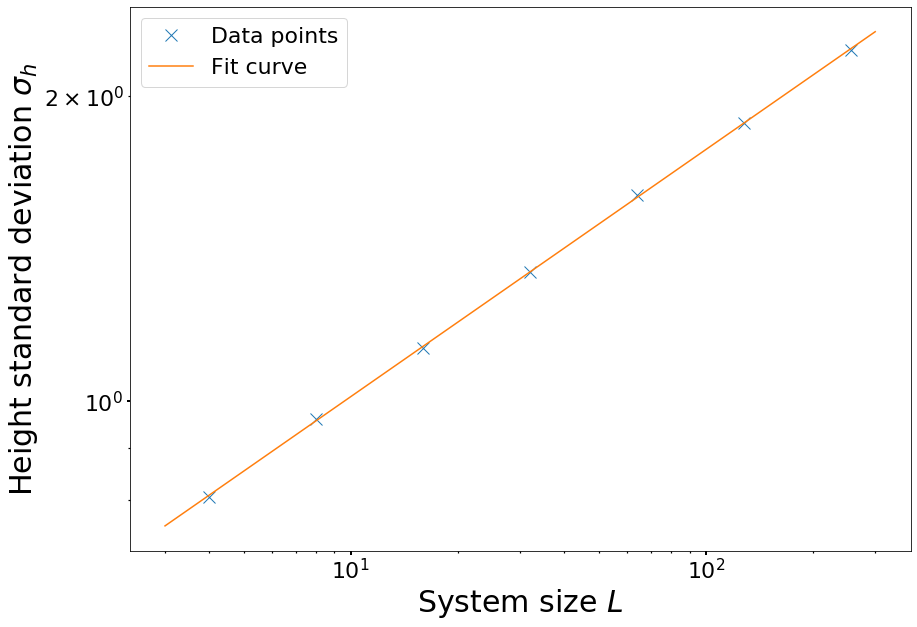

In [183]:
steady_state_heights = np.load('steady_states.npy', allow_pickle=True)
heights_std = [np.std(steady_state_heights[i]) for i in range(len(steady_state_heights))]
plt.loglog(L_list, heights_std, 'x', label='Data points', ms=12)

(a, b), cov = curve_fit(power_func, L_list, heights_std)
x = np.linspace(3, 300)
plt.plot(x,power_func(x, a, b), label='Fit curve')
print("gradient:", b)
std = np.sqrt(np.diag(cov))
print("error:", std)

plt.xlabel("System size $L$", fontsize=30)
plt.ylabel(r"Height standard deviation $\sigma_h$", fontsize=30)
plt.legend()
plt.show()

## Height probability vs Height 

Obtaining height probabilities from steady state height data:

In [20]:
height_freqs = [Counter(steady_state_heights[i]) for i in range(len(steady_state_heights))]
total_config_count = [sum(height_freqs[i].values()) for i in range(len(steady_state_heights))]

height_probs = []
for L in range(len(steady_state_heights)):
    height_prob_config = []
    configs = []
    for (height, count) in sorted(height_freqs[L].items()):
        height_prob_config.append(count/total_config_count[L]) 
        configs.append(height)
    height_probs.append((configs, height_prob_config))

Testing sum of probabilities is 1 for all system sizes:

In [22]:
for L in range(len(L_list)):
    sum_prob = 0
    for i in range(len(height_probs[L])):
        sum_prob = sum(height_probs[L][1])
    print("Sum of height probabilities for system size", L_list[L]," is: ", sum_prob)

Sum of height probabilities for system size 4  is:  1.0
Sum of height probabilities for system size 8  is:  1.0
Sum of height probabilities for system size 16  is:  1.0
Sum of height probabilities for system size 32  is:  1.0
Sum of height probabilities for system size 64  is:  1.0
Sum of height probabilities for system size 128  is:  1.0
Sum of height probabilities for system size 256  is:  1.0


Plot of height probability distribution for all system sizes:

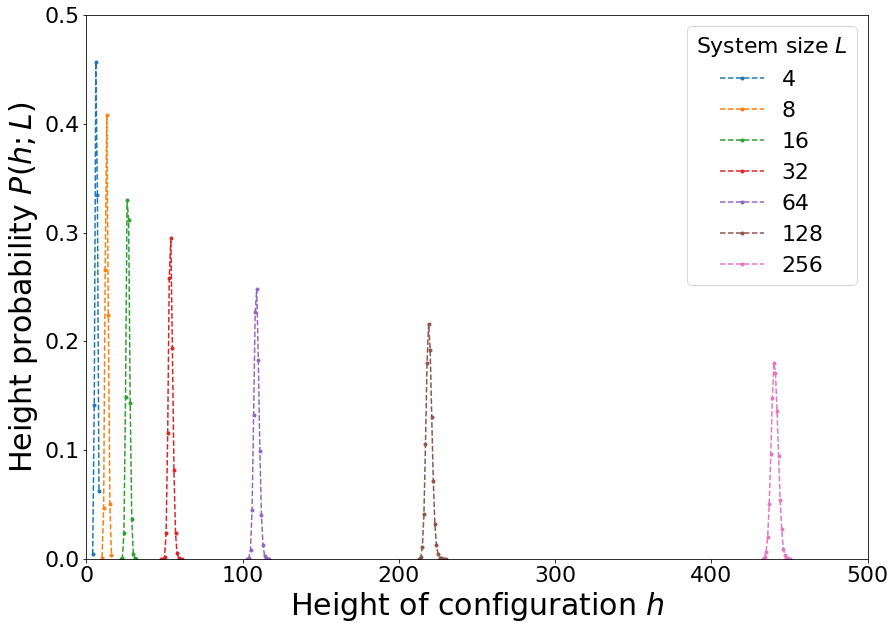

In [58]:
for L in range(len(height_probs)):
    plt.plot(height_probs[L][0], height_probs[L][1], '.--', label=L_list[L])

plt.xlabel("Height of configuration $h$", fontsize=30)
plt.ylabel("Height probability $P(h; L)$", fontsize=30)
plt.legend(title='System size $L$')
plt.axis((0, 500, 0, 0.5))
plt.show()

Partially-collapsed plot of height probability distribution for all system sizes:

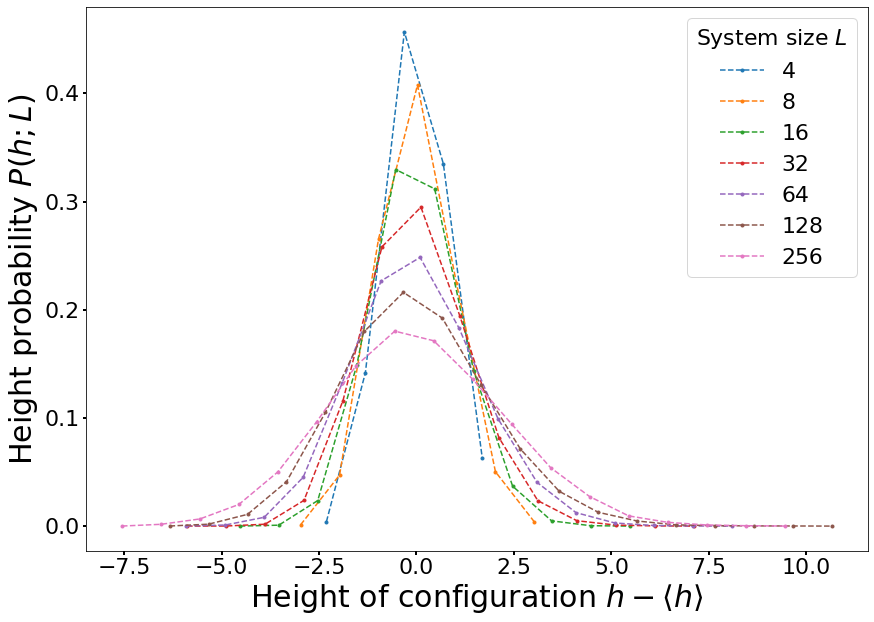

In [153]:
for L in range(len(height_probs)):
    plt.plot(height_probs[L][0] - avg_heights[L], height_probs[L][1], '.--', label=L_list[L])

plt.xlabel(r"Height of configuration $h - \langle h \rangle$", fontsize=30)
plt.ylabel("Height probability $P(h; L)$", fontsize=30)
plt.legend(title="System size $L$")
plt.show()

Fully-collapsed plot of height probability distribution for all system sizes:

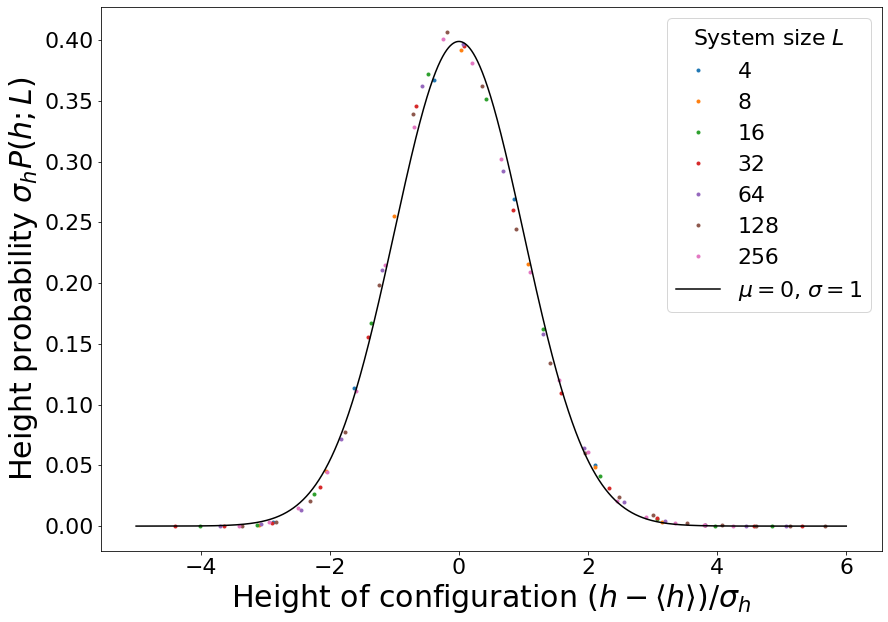

In [41]:
for L in range(len(height_probs)):
    collapsed_height = (height_probs[L][0] - avg_heights[L])/heights_std[L]
    collapsed_prob = np.asarray(height_probs[L][1]) * heights_std[L]
    plt.plot(collapsed_height, collapsed_prob, '.', label=L_list[L])

x = np.linspace(-5,6,10000)
plt.plot(x, gauss_func(x, 0, 1), color='black', label='$\mu = 0$, $\sigma = 1$')

plt.xlabel(r"Height of configuration $(h - \langle h \rangle) /\sigma_h$", fontsize=30)
plt.ylabel("Height probability $\sigma_hP(h; L)$", fontsize=30)
plt.legend(title="System size $L$")
plt.show()

## Avalanche probabilities vs avalanche size

Obtains and saves data for avalanche sized for all system sizes over 10,000 iterations:

In [ ]:
avalanche_sizes = []
iterations = 10000

for L in L_list:
    print(L)
    z, h, pile_height_t, tc, avalanches = oslo(iterations, L, weighting)
    avalanche_sizes.append(avalanches[tc:])
    
np.save('avalanche_sizes_1e4.npy', avalanche_sizes)

Obtains and saves data for avalanche sized for all system sizes over 100,000 iterations:

In [ ]:
avalanche_sizes = []
iterations = 100000

for L in L_list:
    print(L)
    z, h, pile_height_t, tc, avalanches = oslo(iterations, L, weighting)
    avalanche_sizes.append(avalanches[tc:])
    
np.save('avalanche_sizes_1e5.npy', avalanche_sizes)

Obtains and saves data for avalanche sized for all system sizes over 1,000,000 iterations:

In [ ]:
avalanche_sizes = []
iterations = 1000000

for L in L_list:
    print(L)
    z, h, pile_height_t, tc, avalanches = oslo(iterations, L, weighting)
    avalanche_sizes.append(avalanches[tc:])
    
np.save('avalanche_sizes_1e6.npy', avalanche_sizes)

Plots avalanche probability distributions for system of size L=256, for 10,000, 100,000, and 1,000,000 iterations:

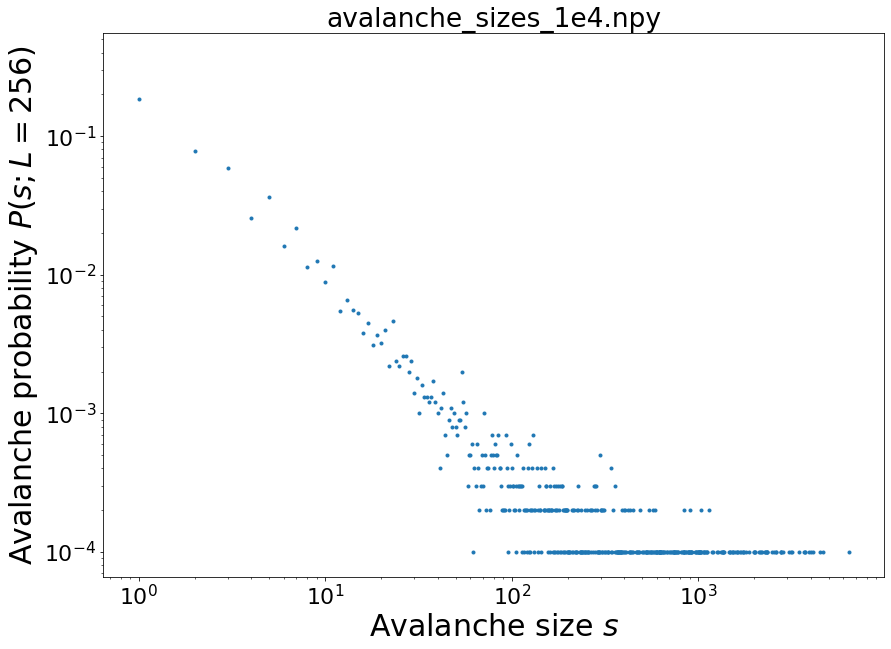

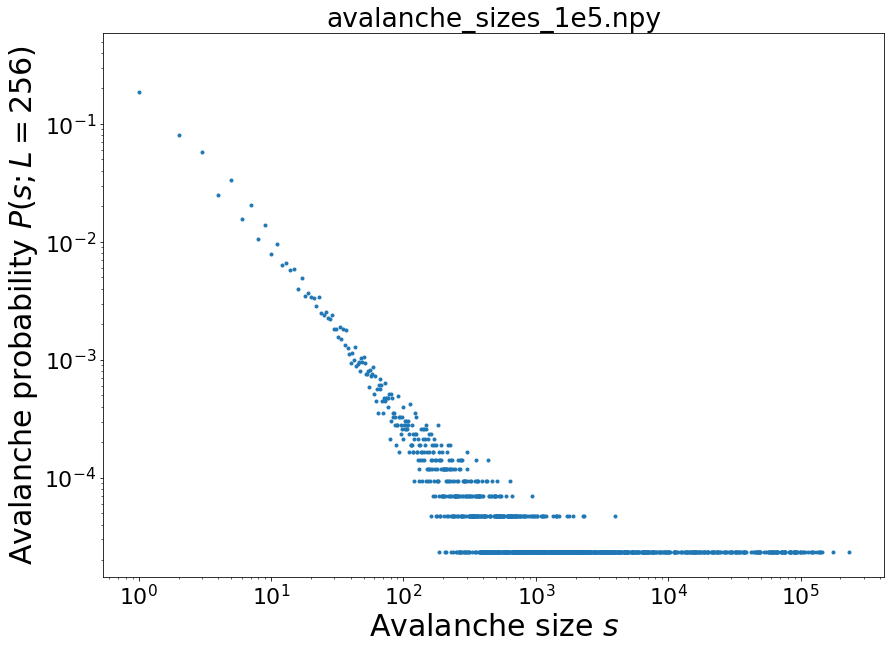

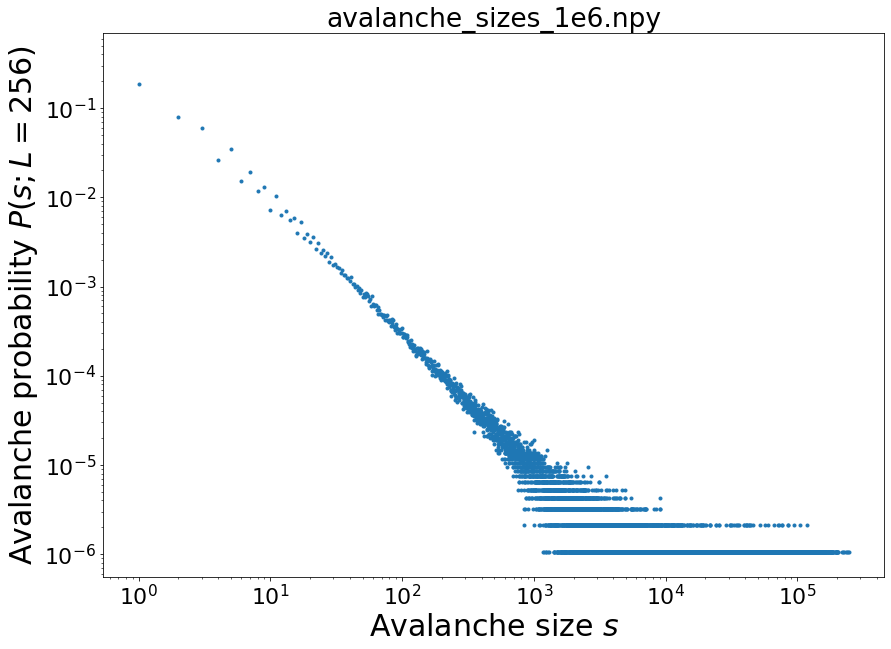

In [498]:
avalanche_sizes_N = ['avalanche_sizes_1e4.npy', 'avalanche_sizes_1e5.npy', 'avalanche_sizes_1e6.npy']

for N in avalanche_sizes_N:
    avalanche_sizes = np.load(N, allow_pickle=True)
    avalanche_freqs = [Counter(avalanche_sizes[i]) for i in range(len(L_list))]
    total_avalanche_count = [sum(avalanche_freqs[i].values()) for i in range(len(L_list))]

    avalanche_probs = []
    for L in range(len(L_list)):
        avalanche_prob = []
        avalanche_size = []
        for (size, count) in sorted(avalanche_freqs[L].items()):
            avalanche_prob.append(count/total_avalanche_count[L]) 
            avalanche_size.append(size)
        avalanche_probs.append((avalanche_size, avalanche_prob))

    plt.loglog(avalanche_probs[6][0], avalanche_probs[6][1], '.',label=L_list[6])
    plt.xlabel("Avalanche size $s$", fontsize=30)
    plt.ylabel("Avalanche probability $P(s; L=256)$", fontsize=30)
    plt.title(N)
    plt.show()

Testing sum of probabilities is 1 for all system sizes:

In [473]:
for L in range(len(L_list)):
    sum_prob = 0
    for i in range(len(avalanche_probs[L])):
        sum_prob = sum(avalanche_probs[L][1])
    print("Sum of avalanche probabilities for system size", L_list[L]," is: ", sum_prob)

Sum of avalanche probabilities for system size 4  is:  1.0000000000000002
Sum of avalanche probabilities for system size 8  is:  0.9999999999999998
Sum of avalanche probabilities for system size 16  is:  1.0000000000000004
Sum of avalanche probabilities for system size 32  is:  1.000000000000002
Sum of avalanche probabilities for system size 64  is:  0.9999999999999246
Sum of avalanche probabilities for system size 128  is:  0.9999999999996577
Sum of avalanche probabilities for system size 256  is:  1.0000000000001714


Plots avalanche probability distribution for L=256 for 10,000, 100,000, and 1,000,000 iterations, with log-binned data:

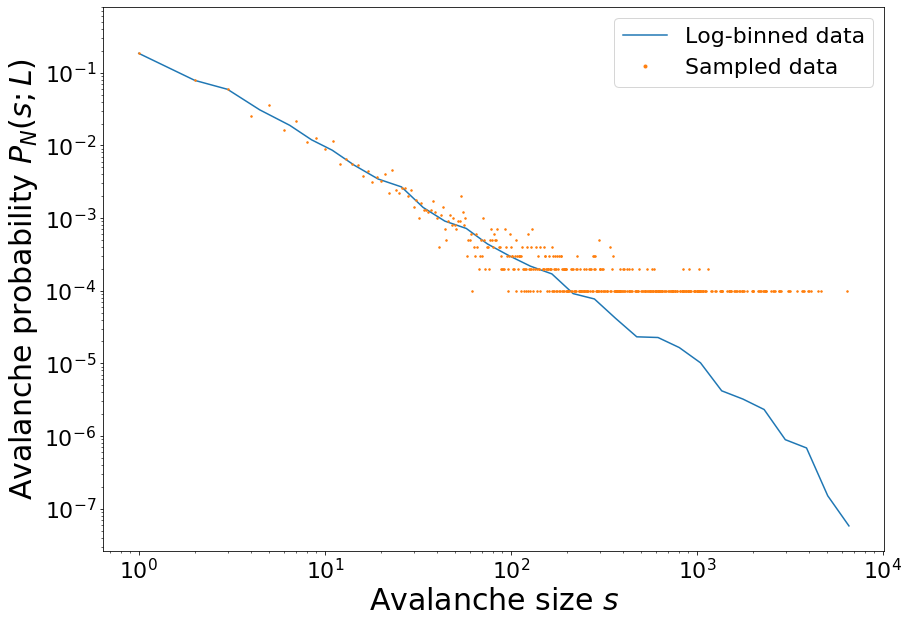

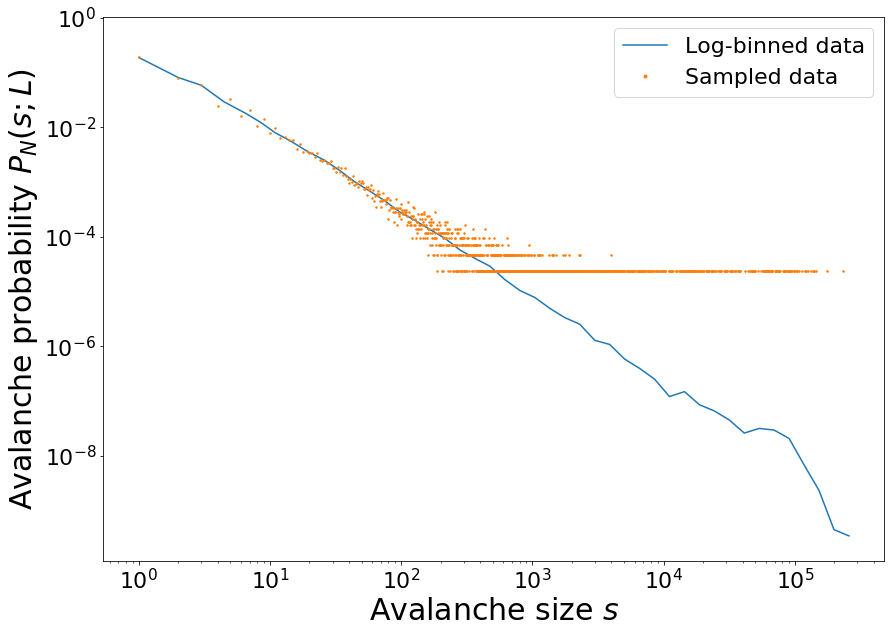

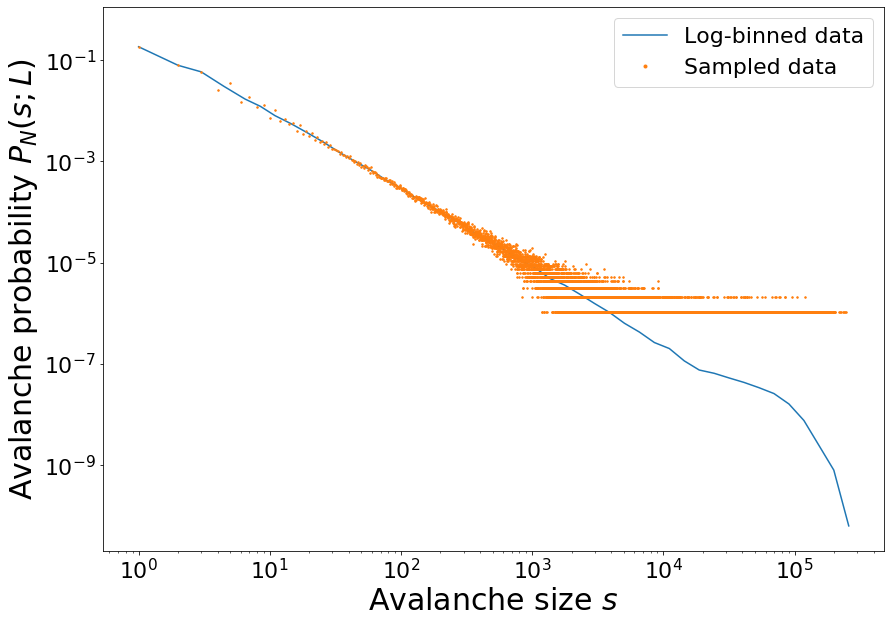

In [59]:
avalanche_sizes_N = ['avalanche_sizes_1e4.npy', 'avalanche_sizes_1e5.npy', 'avalanche_sizes_1e6.npy']

for N in avalanche_sizes_N:
    avalanche_sizes = np.load(N, allow_pickle=True)
    avalanche_freqs = [Counter(avalanche_sizes[i]) for i in range(len(L_list))]
    total_avalanche_count = [sum(avalanche_freqs[i].values()) for i in range(len(L_list))]
    bin_centres, bin_probs = logbin(avalanche_sizes[6], scale=1.3, zeros=False)
    
    avalanche_probs = []
    for L in range(len(L_list)):
        avalanche_prob = []
        avalanche_size = []
        for (size, count) in sorted(avalanche_freqs[L].items()):
            avalanche_prob.append(count/total_avalanche_count[L]) 
            avalanche_size.append(size)
        avalanche_probs.append([avalanche_size, avalanche_prob])

    plt.loglog(bin_centres, bin_probs, label="Log-binned data")
    plt.loglog(avalanche_probs[6][0], avalanche_probs[6][1], '.', markersize=3, label="Sampled data")
    plt.xlabel("Avalanche size $s$", fontsize=30)
    plt.ylabel("Avalanche probability $P_N(s; L)$", fontsize=30)
    plt.legend(markerscale=2)
    plt.show()

Plots log-binned avalanche probability distributions for all system sizes over 1,000,000 iterations:

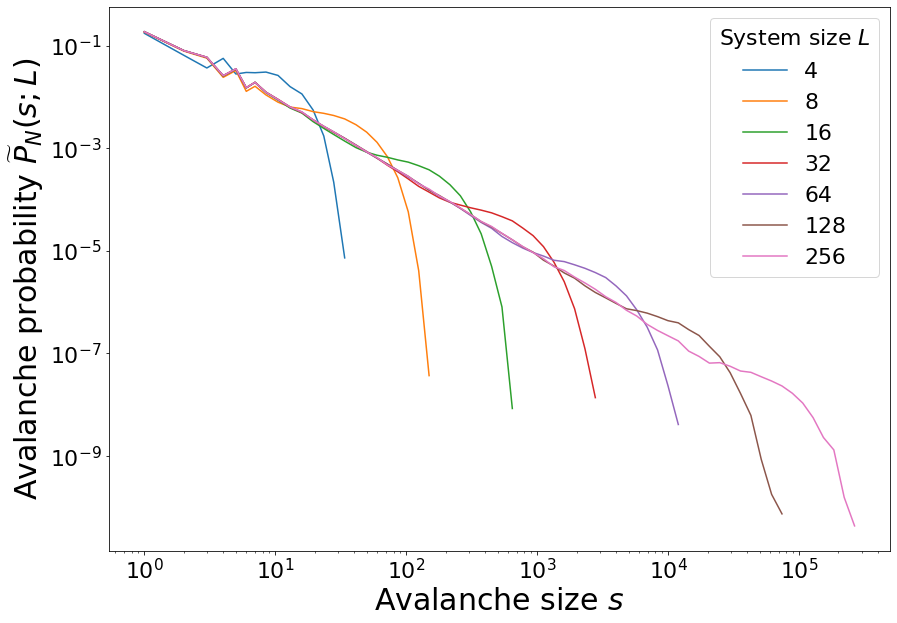

In [66]:
avalanche_sizes = np.load('avalanche_sizes_1e6.npy', allow_pickle=True)

for L in range(len(L_list)):
    bin_centres, bin_probs = logbin(avalanche_sizes[L], scale=1.2, zeros=False)
    plt.loglog(bin_centres, bin_probs, label=L_list[L])
    
plt.xlabel("Avalanche size $s$", fontsize=30)
plt.ylabel(r"Avalanche probability $\widetilde P_N(s; L)$", fontsize=30)
plt.legend(title='System size $L$')
plt.show() 

## Finite-size scaling of avalanche probabilities

Plots partially-collapsed log-binned avalanche probability distribution for all system sizes over 1,000,000 iterations:

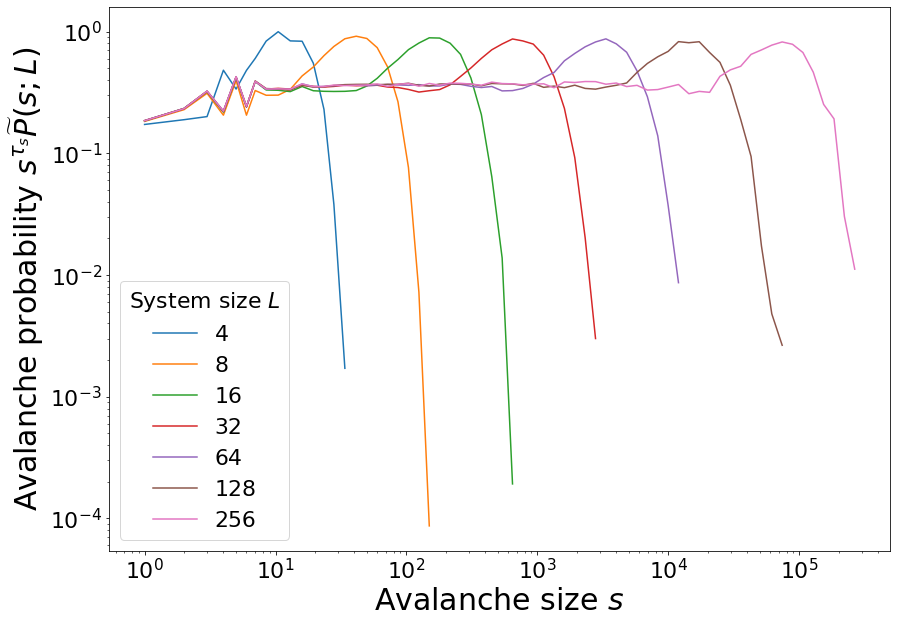

In [67]:
avalanche_sizes = np.load('avalanche_sizes_1e6.npy', allow_pickle=True)

tau_s = 1.55
for L in range(len(L_list)):
    bin_centres, bin_probs = logbin(avalanche_sizes[L], scale=1.2, zeros=False)
    plt.loglog(bin_centres, bin_probs * bin_centres**tau_s, label=L_list[L])
    
plt.xlabel("Avalanche size $s$", fontsize=30)
plt.ylabel(r"Avalanche probability $s^{\tau_s} \widetilde P(s; L)$", fontsize=30)
plt.legend(title='System size $L$')
plt.show() 

Plots fully-collapsed log-binned avalanche probability distribution for all system sizes over 1,000,000 iterations:

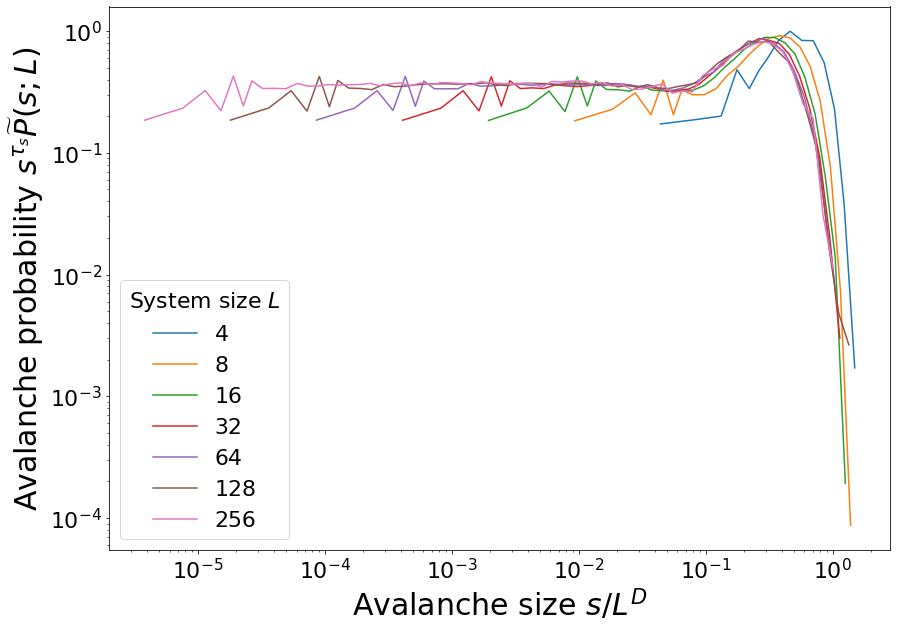

In [70]:
tau_s = 1.55
D = 2.25
for L in range(len(L_list)):
    bin_centres, bin_probs = logbin(avalanche_sizes[L], scale=1.2, zeros=False)
    plt.loglog(bin_centres / L_list[L]**D, bin_probs * bin_centres**tau_s, label=L_list[L])
    
plt.xlabel(r"Avalanche size $s/L^D$", fontsize=30)
plt.ylabel(r"Avalanche probability $s^{\tau_s} \widetilde P(s; L)$", fontsize=30)
plt.legend(title='System size $L$')
plt.show() 

## Avalanche-size moments

Obtains k'th moments of avalanche sizes for all system sizes over 1,000,000 iterations:

In [6]:
avalanche_sizes = np.load('avalanche_sizes_1e6.npy', allow_pickle=True)
L_list = [4, 8, 16, 32, 64, 128, 256]
k_list = [1, 2, 3, 4, 5]

moments = []
for k in k_list:
    kth_moments = []
    for L in range(len(L_list)):
        kth_moment = np.average(np.asarray(avalanche_sizes[L], dtype='float64') ** k)
        kth_moments.append(kth_moment)
    moments.append(kth_moments)

Plot of moments vs. system size for range of k values, with fitted lines to the largest three system sizes of each plot:

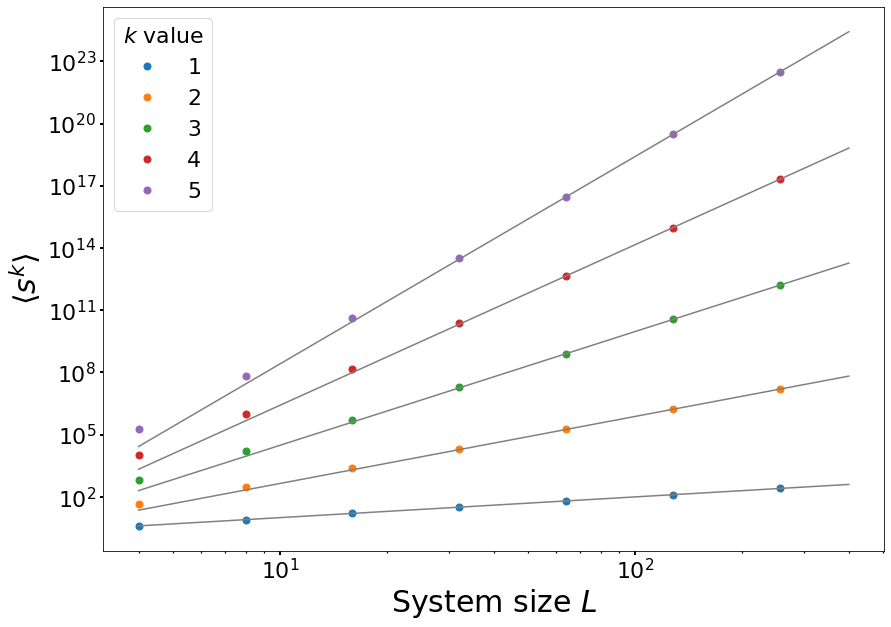

In [14]:
a_list = []
b_list = []
k_grad = []
k_grad_err = []
x = np.linspace(4, 400)
for k in range(len(k_list)):
    plt.loglog(L_list[:], moments[k][:], '.', markersize=14, label=k_list[k])   
    (a, b), cov = curve_fit(linear_func, np.log(L_list[4:]), np.log(moments[k][4:]))
    k_grad.append(a)
    std = np.sqrt(np.diag(cov))[0]
    k_grad_err.append(std)
    plt.plot(x, power_func(x, np.exp(b), a), color='grey')

plt.xlabel("System size $L$", fontsize=30)
plt.ylabel(r"$\langle s^k \rangle$", fontsize=30)
plt.legend(title="$k$ value")
plt.show()

Shows gradients and associated errors of each line in the above plot:

In [15]:
print(k_grad)
print(k_grad_err)

[0.9997955440070502, 3.232078944844387, 5.485511789209031, 7.742857264815729, 10.000548053062966]
[6.367697987819522e-05, 0.014513672044898968, 0.01425879105858448, 0.003860999202889476, 0.04441329112667681]


Plots gradients of above plot vs. k, and fits line of best fit:

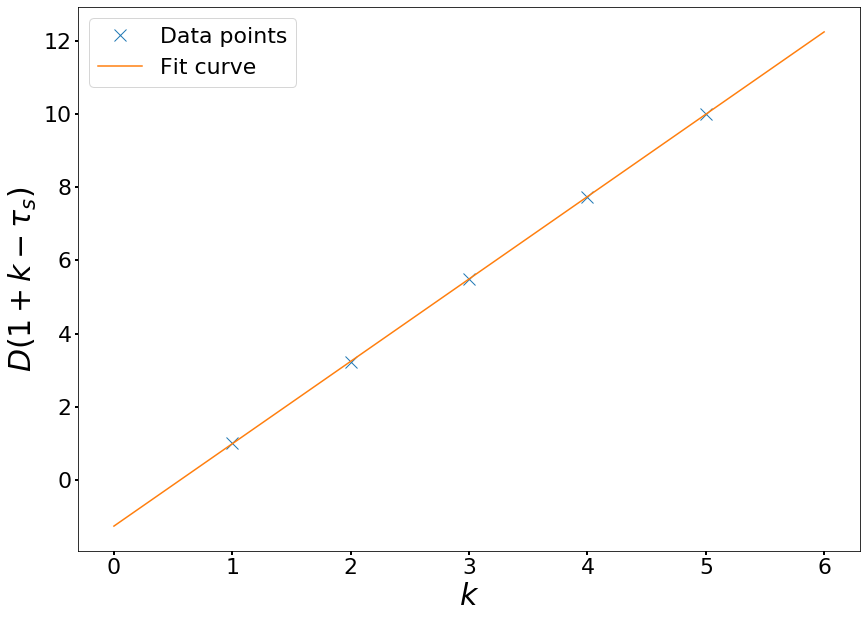

In [16]:
plt.plot(k_list, k_grad, 'x', label='Data points', ms=12)
(a, b), cov = curve_fit(linear_func, k_list, k_grad)
x = np.linspace(0, 6)
plt.plot(x, linear_func(x, a, b), label='Fit curve')
plt.xlabel("$k$", fontsize=30)
plt.ylabel(r"$D(1+k-\tau_s$)", fontsize=30)
plt.legend()
plt.show()

Obtains values and associated errors for critical exponents D and $\tau_s$:

In [17]:
std = np.sqrt(np.diag(cov))
print("gradient:", a)
print("gradient error:", std[0])
print("y-intercept:", b)
print("y-intercept error:", std[1])
tau_s = -b/a + 1
D = a
print("D:", D)
print("tau_s:", tau_s)

gradient: 2.251228333844086
gradient error: 0.0029432718465254937
y-intercept: -1.2615266823682716
y-intercept error: 0.00976172822131922
D: 2.251228333844086
tau_s: 1.5603726034374092


Scaled plot of moments vs. system size to demonstrate corrections to scaling:

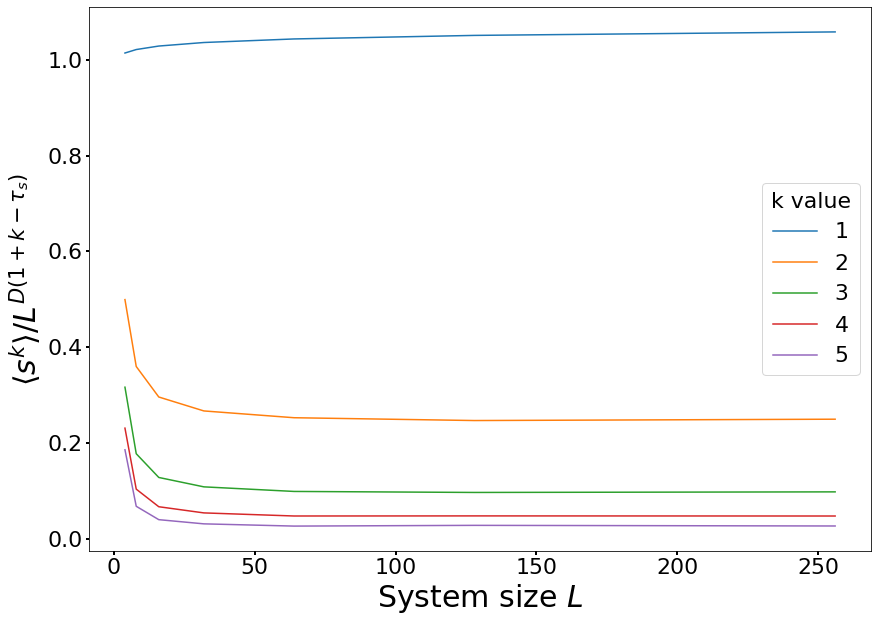

In [18]:
a_list = []
b_list = []
k_grad = []
k_grad_err = []
L_s = np.linspace(0, 400)
for k in range(len(k_list)):
    plt.plot(L_list, moments[k] / (L_list**(D*(1 + k_list[k] - tau_s))), '-', label=k_list[k]) 

plt.xlabel("System size $L$", fontsize=30)
plt.ylabel(r"$\langle s^k \rangle/L^{D(1+k-\tau_s)}$", fontsize=30)
plt.legend(title="k value")
plt.show()